# Visualising the embedding space of CLIP

This notebook visualises the PCA- or t-SNE- transformed embedding space of CLIP for two settings:
* vanilla: visualising unrelated 10 image and 10 object category embeddings,
* best_match: visualising the best-matching image and object category pair for a specific image.

Note: We assume that you have caches these files, in their corresponding directory:
* image embeddings dictionary (keys=image ids, values=image embeddings): '../data/cache/image_emb.pickle'
* object embeddings numpy array: '../data/cache/object_emb.npy'
* object names text file: '../data/cache/object_texts.txt'
* places names text file: '../data/cache/place_texts.txt'

### Set-up

In [1]:
# Loading the required packages
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random
%matplotlib inline
# If you want to view plots interactively, please uncomment the following line
# %matplotlib notebook 

# Analysis-specific packages
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Loading image and object embeddings

In [2]:
# Image embeddings
img_emb_path = '../data/cache/image_emb.pickle'

with open(img_emb_path, 'rb') as f:
    img_emb = pickle.load(f)

clip_feat_dim = 768
img_feats = np.zeros((len(img_emb.keys()), clip_feat_dim), dtype=np.float32)
img_texts = []

for ix, (img_id, emb) in enumerate(img_emb.items()):
    img_feats[ix, :] = emb
    img_texts.append(str(img_id))

In [3]:
# Object category embeddings
obj_emb_path = '../data/cache/object_emb.npy'
obj_txt_path = '../data/cache/object_texts.txt'
plc_txt_path = '../data/cache/place_texts.txt'

object_feats = np.load(obj_emb_path)
with open(obj_txt_path) as fid:
    object_texts = fid.readlines()
with open(plc_txt_path) as fid:
    place_texts = fid.readlines()   

# Remove redundant categories
object_texts = [o for o in list(set(object_texts)) if o not in place_texts] 

### Choose approach

In [4]:
approach = 'best_match'
# approach = 'best_match'

# PCA and t-SNE on the embedding space of CLIP corresponding to object embeddings 
* For now the first 100 objects only

In [5]:
# A helper function to store colors for plots

# Generate a list of n random colors
def generate_colors(n):
    '''This function generates a list of colors'''
    colors = []
    for _ in range(10):
        # Generate a random RGB value for each color
        r = random.random()
        g = random.random()
        b = random.random()
        color = (r, g, b)
        colors.append(color)
    return colors

In [6]:
# Step 1: Have relevant CLIP embeddings for the image and object data

# Consider possibly unrelated images and words
if approach == 'vanilla':
    # Choose number of images/object categories to plot
    n = 25
    
    # Every row is an embedding vector of one object or image
    embeddings = np.vstack((object_feats[:n, :], img_feats[:n, :]))
    items_to_analyse = object_texts[:n] + img_texts[:n]
    
    # Color-wise, there are 10 images and then 10 objects 
    cols = n*['blue'] + n*['orange']

    
# Consider images with a best match words
elif approach == 'best_match':
    # Choose number of images/object categories to plot
    n = 10
    
    # Color-wise, there are 10 images and then 10 objects
    cols = generate_colors(n)
    cols = cols + cols
    
    embeddings = img_feats[:n, :]
    items_to_analyse = img_texts[:n]

    # ixs = np.random.choice(img_feats.shape[0], n)
    # print(ixs)

    for ix in range(n):
        results_vec = object_feats @ img_feats[ix].T
        best_match_ix = np.where(results_vec == sorted(results_vec, reverse=True)[0])
        best_match_ix = int(best_match_ix[0])
        embeddings = np.vstack((embeddings, object_feats[best_match_ix, :].squeeze()))
        items_to_analyse.append(object_texts[best_match_ix])  

# Check whether the dims are correct
print(embeddings.shape)

(20, 768)


In [7]:
# Step 2: Normalize the embeddings
normalized_embeddings = (embeddings - np.mean(embeddings, axis=0)) / np.std(embeddings, axis=0)

# Sample print
print(normalized_embeddings[:4, :4])

[[ 0.87758714  0.8083599   0.5277441   0.32528874]
 [-0.4128633   1.4629568  -0.3174339  -0.33287498]
 [ 0.0061339   0.7023102   0.26391828  0.05278116]
 [ 0.42188016 -0.24673657  0.4838357  -0.884719  ]]


In [12]:
# Step 3: Choose the number of dimensions
num_dimensions = 2

In [13]:
# Step 4: Perform PCA or t-SNE
if num_dimensions == 2:
    print('Performing t-SNE...')

    # Use t-SNE for 2D visualization
    tsne = TSNE(n_components=num_dimensions, perplexity=5.0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
else:
    print('Performing PCA...')

    # Use PCA for higher-dimensional visualization
    pca = PCA(n_components=num_dimensions)
    reduced_embeddings = pca.fit_transform(normalized_embeddings)

Performing t-SNE...


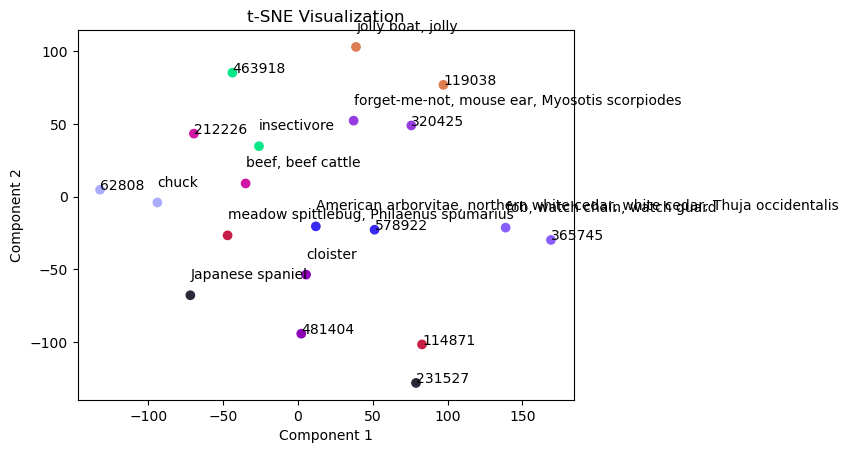

In [14]:
# # Step 5: Visualize the results (2D)
if num_dimensions == 2:
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cols)

    # Annotate the plot with the labels
    for i, label in enumerate(items_to_analyse):
        plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

    # Add labels and title to the plot
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('t-SNE Visualization')

    plt.show()

In [15]:
# Step 5: Visualize the results (3D)
if num_dimensions != 2:

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    # Data for three-dimensional scattered points
    xdata = reduced_embeddings[:, 0]
    ydata = reduced_embeddings[:, 1]
    zdata = reduced_embeddings[:, 2]
    ax.scatter3D(xdata, ydata, zdata, c=cols)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')


    for i, text in enumerate(items_to_analyse):
        ax.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], text, fontsize=7)

Working with PCA or t-SNE would probably require us to set some threshold on the similarity between two words to determine whether they are synonyms:
* For example by taking dot product/cosine similarities between the embeddings of the two objects.

\
           
1. One way out of this is to perform clustering (k-means/Gaussian mixtures)
    * Drawback: need to set k, and this would have to be informed by the dataset for the objects/places we are using

\

2. Another possibility would be to not do a PCA or t-SNE but instead do a search through the combinations of the first n most fitting descriptor words and pick one combination that would produce the highest similarity with the image
    * Brute-force search: computationally intensive
    * Searching among the centroids created by clustering the objects

\

This method could not work for images that contain a lot of similar objects (say, three different kinds of fruit), since we would filter similar words being captioned simultaneously.